# Deep CNN Image Classifer - Happy or Sad
## 1. Setup and Load Data
#### 1.1 Install Dependencies and Setup

In [1]:
# Tensorflow and tensorflow-gpu are used as part of the pipeline for deep learning along with keras api
# OpenCV is used to remove the dodgy images
# Matplotlib is used for visualization

# %conda install tensorflow tensorflow-gpu opencv-python matplotlib

In [2]:
# Check to see we have all the dependencies installed
# %conda list

In [3]:
# Import dependencies
import tensorflow as tf
import os  # os is used to navigate through file structures 
# Example
os.path.join('data', 'happy')  # Joins data and happy together as a path (According to structure of users machine)
# Example
# os.listdir('FileName')  # Will shows all files in this directory  

'data\\happy'

In [4]:
# Avoid OOM (OUT Of Memory) errors by setting GPU Memory Consumption Growth
# This limits how much of the VRAM on the GPU Tensorflow will use. By default when you load or load in data to Tensorflow, it will use all the potential VRAM that is available.

allDevices = tf.config.experimental.list_physical_devices()  #Grabs all available devices
gpus = tf.config.experimental.list_physical_devices("GPU")  # Grabs all available GPUs on machine

# Limits the memory growth by looping though all GPU in GPUS. Tells Tensorflow to oly use memory that is needed
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)  

# Print is optional but I like to use it for readability
print(allDevices)
print(gpus)
print(len(gpus))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1


#### 1.2 Remove Dodgy Images

In [5]:
# Now it is time to gather the images and then remove any dodgy images in the next steps
import cv2
import imghdr

In [6]:
dataDir = 'data'  # Variable that points to the data folder
# print(os.listdir(dataDir))  #   Lists what is inside of the data folder
# print(os.listdir(os.path.join(dataDir, 'happy')))  # Lists inside happy folder

In [7]:
imageExts = ['jpeg', 'jpeg', 'bmp', 'png']  # Creates a list will all the possible image extensions we want in the model

(1000, 736, 3)


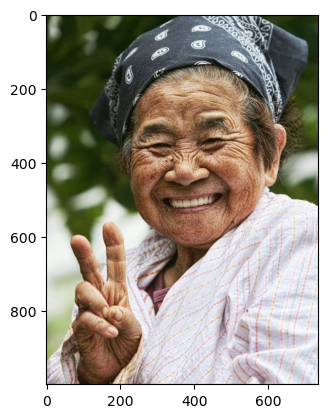

In [8]:
# NOT NEEDED, JUST HERE FOR TESTING
image = cv2.imread(os.path.join('data', 'happy', '5af07aa5a2beade6faa5b36344b04030--okinawa-japan-wabi-sabi.jpg'))  # Testing to see how the image is loaded
#print(image)
print(image.shape)  # Prints out the height, width, and whether the image is coloured
from matplotlib import pyplot as plt
# plt.imshow(image)  # Uses matplotlib to display the image
# Note: OpenCV reads an image as BGR but Matplotlib reads it in RGB. To fix this we convert the image from BDG to RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [9]:
# We will loop through this list with the images we have and remove any that don't contain these extensions

for imageClass in os.listdir(dataDir):  # Loops through happy and sad folders
    for image in os.listdir(os.path.join(dataDir, imageClass)):  # Loops through each photo
        imagePath = os.path.join(dataDir, imageClass, image)
        try:
            image = cv2.imread(imagePath)  # Check if image can be opened in OpenCV. The image is read in as a numpy array
            tip = imghdr.what(imagePath)
            if tip not in imageExts:  # Check to see if image matches extensions
                print('Image not in extension list {}'.format(imagePath))
                os.remove(imagePath)  # Removes the unwanted image
        except Exception as e:
            print('Issue with image {}'.format(imagePath))

#### 1.3 Load Data

In [10]:
# Tensorflow has a built in dataset API. This allows you to build data pipelines. This allows you to scale out to larger datasets while also allowing you to repeat steps you are going to apply to the data. This also means we don't have to load the data straight into the memory.

# Dataset documentation
# tf.data.Dataset??

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# More Documentation
# tf.keras.utils.image_dataset_from_directory??
#  Can change these properties if we wanted to

In [13]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=24)  # Builds an image dataset using the built in keras function. This means I don't have to build the labels or classes. Builds data pipeline

Found 165 files belonging to 2 classes.


In [14]:
dataIterator = data.as_numpy_iterator()  # Convert to numpy iterator to access data pipeline

In [15]:
batch = dataIterator.next()  # Grab another batch from the iterator/pipeline

print(len(batch))
# print(batch[0])  # Images represented as numpy arrays
# print(batch[1])  # Image Labels (0 and 1)
print(batch[0].shape)  # From here we can see each batch has 24 images

2
(24, 256, 256, 3)


[0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0]


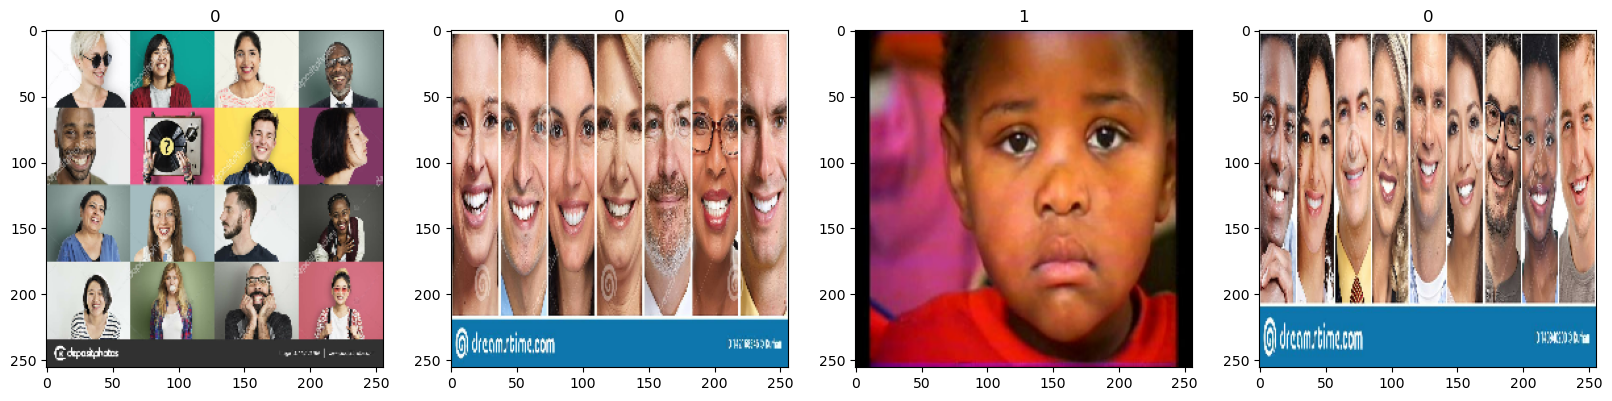

In [16]:
# Figure out which class is 1 and which class is 0

print(batch[1])

figure, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

# From here we can see that class 0 is happy and class 1 is sad

## 2. Preprocess Data
#### 2.1 Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))  # As we load in batch, get X value and divide by 255 to scale all the data between 0 - 1




In [18]:
scaledIterator = data.as_numpy_iterator()

In [19]:
batch = scaledIterator.next()

In [20]:
print(batch[0].max())
print(batch[0].min())

1.0
0.0


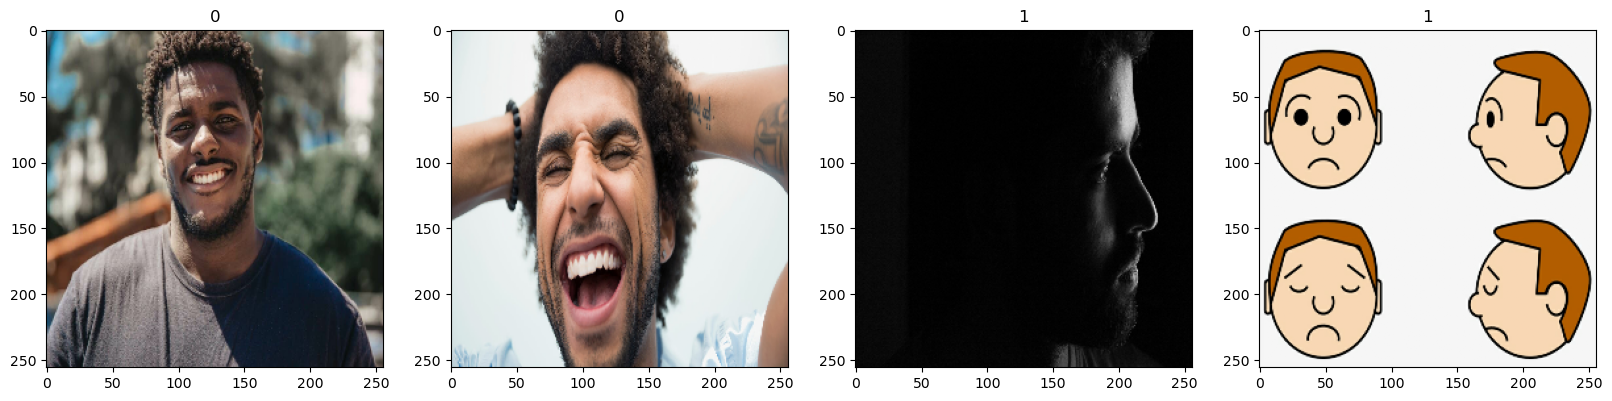

In [21]:
figure, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img)
    ax[index].title.set_text(batch[1][index])

#### 2.2 Split Data

In [22]:
len(data)

7

In [23]:
trainSize = int(len(data)*.7)  # Training set is 70% of data
valSize = int(len(data)*.2)+1  # Validation is 20% of data
testSize = int(len(data)*.1)+1  # Testing is 10% of data
print(trainSize, valSize, testSize)

4 2 1


In [24]:
train = data.take(trainSize)  # Takes the amount of batches equal to the training size
val = data.skip(trainSize).take(valSize)  # Skip the first batches for training and take in the batches for validation
test = data.skip(trainSize+valSize).take(testSize)  # Skip the batches for training and validation and take the batches for testing

## 3. Deep Model
#### 3.1 Build Deep Learning Model

In [25]:
# Importing dependencies from Tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # These are the different layers in the Neural Network

In [26]:
model = Sequential()

In [27]:
# MaxPooling2D??

In [28]:
# Adding all the layers to the neural network
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))  # First layer of the neural network that passes in an input. It has 16 3x3 pixel Filters with 1 pixel strides. The activation function is the Relu function. This allows the particular neuron to turn on when the data meets a particular threshold. For this function, any outputs below 0 will be off (0) while above will be on (unchanged). Many other functions are used in neural networks, such as the Sigmoid function. These functions are the key to these models.
model.add(MaxPooling2D())  # Condense the information by taking the maximum value over a set region, 2x2, in this case, halving the output.

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())  # Condense the data into a single value. Multiplies the dimensions together. If you look bellow, we can see that is 30x30x16=14400

# These are the fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Outputs 0 or 1 for Happy and Sad

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()  # See how the model takes in data

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

#### 3.2 Train Model

In [31]:
logdir='logs'

In [32]:
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  # Log out the model training as it trains. We can see how it performs over time.

In [33]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboardCallback])
#  To run Tensorboard, type "ctrl, shift, p", select python: launch tensorboard. For me I set a shortcut with "ctrl, alt, t"

Epoch 1/20
4/4 [==============================] - 8s 292ms/step - loss: 1.1354 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.3958
Epoch 2/20
4/4 [==============================] - 1s 171ms/step - loss: 0.6547 - accuracy: 0.6042 - val_loss: 0.6701 - val_accuracy: 0.6042
Epoch 3/20
4/4 [==============================] - 1s 174ms/step - loss: 0.6386 - accuracy: 0.6146 - val_loss: 0.5843 - val_accuracy: 0.6667
Epoch 4/20
4/4 [==============================] - 1s 249ms/step - loss: 0.5743 - accuracy: 0.6875 - val_loss: 0.5676 - val_accuracy: 0.6042
Epoch 5/20
4/4 [==============================] - 1s 165ms/step - loss: 0.5410 - accuracy: 0.6354 - val_loss: 0.5453 - val_accuracy: 0.7500
Epoch 6/20
4/4 [==============================] - 1s 155ms/step - loss: 0.4875 - accuracy: 0.7917 - val_loss: 0.4113 - val_accuracy: 0.6875
Epoch 7/20
4/4 [==============================] - 1s 155ms/step - loss: 0.4229 - accuracy: 0.8229 - val_loss: 0.3162 - val_accuracy: 0.9167
Epoch 8/20
4/4 [====

#### 3.3 Plot Performance

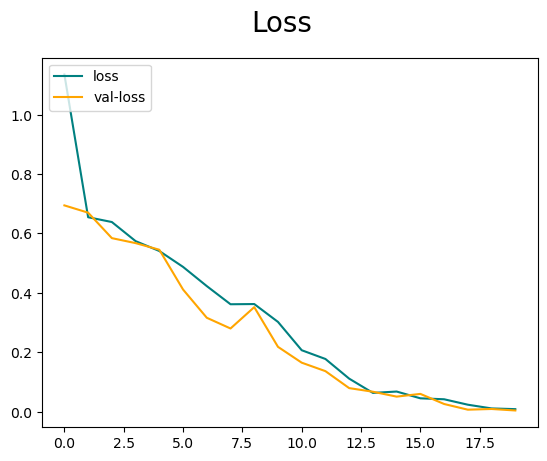

In [34]:
figure = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val-loss')
figure.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

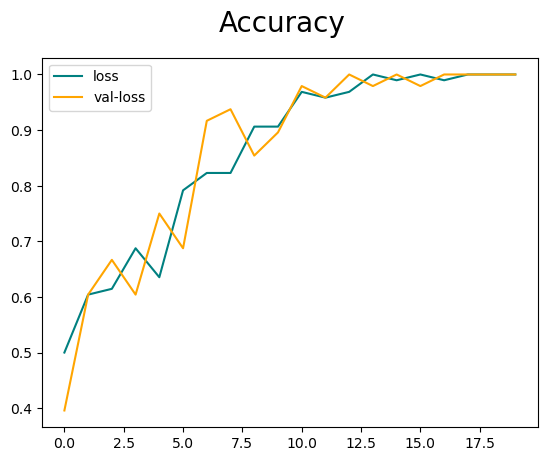

In [35]:
figure = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='loss')
plt.plot(history.history['val_accuracy'], color='orange', label='val-loss')
figure.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Evaluate Performance
#### 4.1 Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [39]:
print(f'Precicion: {precision.result()}, Recall: {recall.result()}, Accuracy: {accuracy.result()}')  # Higher value means we are preforming better

Precicion: 1.0, Recall: 1.0, Accuracy: 1.0


#### 4.2 Test

In [40]:
image = cv2.imread(os.path.join('testing', 'sadTest.jpg'))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()

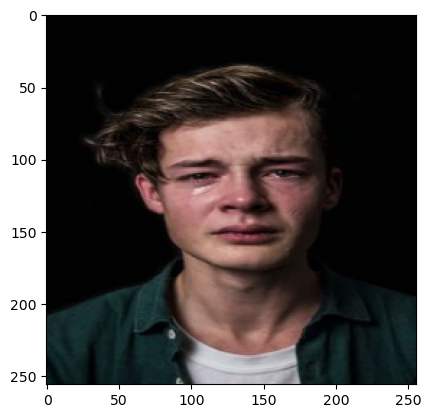

In [41]:
resize = tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
print(resize.shape)
print(np.expand_dims(resize, 0).shape)

(256, 256, 3)
(1, 256, 256, 3)


In [43]:
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

[[0.9997522]]


In [44]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## 5. Save the Model
#### 5.1 Save the Model

In [45]:
from tensorflow.keras.models import load_model
# import tensorflow as tf
# import os
# from matplotlib import pyplot as plt
# import imghdr 
# import numpy as np
# import cv2

In [46]:
model.save(os.path.join('models', 'happySadModel5.h5'))

In [47]:
newModel = load_model(os.path.join('models', 'happySadModel2.h5'))
print(newModel)

In [48]:
image = cv2.imread(os.path.join('testing', 'happyTest.jpg'))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()

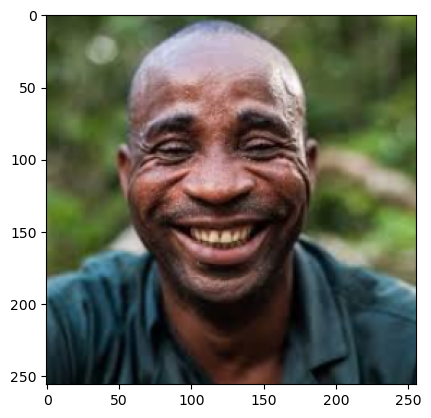

In [49]:
resize = tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [50]:
yhatnew = newModel.predict(np.expand_dims(resize/255, 0))

In [51]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
